> reverse engineering

- https://www.lesswrong.com/posts/hnzHrdqn3nrjveayv/how-to-transformer-mechanistic-interpretability-in-50-lines
    - https://www.neelnanda.io/mechanistic-interpretability/getting-started
- https://docs.google.com/presentation/d/1BkAjGqIqgomQpj6j0-oZORCeq72sH7_sOPjlflnYm_A/edit?pli=1#slide=id.p

In [1]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [17]:
import transformer_lens
from transformer_lens import utils
from transformer_lens import HookedTransformer
import torch
from functools import partial

### lens definition

- model cfg
    - https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedTransformerConfig.html
- `logits, cache = mode.run_witch_cache(dataset)`
    - 运行模型时同时捕获中间计算结果（通常是某些层或模块的输出）以便后续分析和调试
    - `cache["pattern", layer, "attn"]`: 从指定的 layer 层获取 attn 注意力模块的注意力模式（权重）。
        - 形状为 [batch_size, num_heads, seq_length, seq_length] 的张量，包含注意力权重。
    - `cache["pre", layer, "mlp"]`: 从指定的 layer 层获取 MLP 模块的预激活输出。
        - 形状为 [batch_size, seq_length, d_model] 的张量，包含在激活函数应用之前的值。
    - `cache["post", layer, "mlp"]`: 从指定的 layer 层获取 MLP 模块的后激活输出。
        - 形状为 [batch_size, seq_length, d_model] 的张量，包含在激活函数应用之后的值。
- `model.run_with_hooks(..., fwd_hooks=[])`
    - Runs the model with specified forward and backward hooks.

### modules

- Embed()/Unembed()
    - Embed: W_E
    - Unembed: W_U
- MLP()
    - W_in
    - W_out
- Attention()
    - QKVO:
        - W(weights)
            - W_Q, W_K, W_V, W_O
        - b(biases)
            - b_Q, b_K, b_V, b_O

### utils

In [3]:
utils.get_act_name("post", 1)

'blocks.1.mlp.hook_post'

### tokens

- model.to_string
    - id => string
- model.to_str_tokens
    - id => token
- model.to_single_token
    - string => id

In [30]:
model = HookedTransformer.from_pretrained("gelu-1l").to(torch.float32)

Loaded pretrained model gelu-1l into HookedTransformer
Changing model dtype to torch.float32


/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
model.cfg.d_vocab

48262

In [32]:
model.to_str_tokens(torch.arange(10))

['<|EOS|>', '<|BOS|>', '<|PAD|>', '!', '"', '#', '$', '%', '&', "'"]

In [33]:
model.to_single_token('hello')

24684

In [34]:
model.to_string(24684)

'hello'

### basic usage

In [3]:
# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
logits = model("Famous computer scientist Alan")

In [6]:
model.to_tokens("Famous computer scientist Alan")

tensor([[50256,    37, 10877,  3644, 11444, 12246]], device='cuda:0')

In [5]:
logits.shape

torch.Size([1, 6, 50257])

In [11]:
# The logit dimensions are: [batch, position, vocab]
next_token_logits = logits[0, -1]
next_token_prediction = next_token_logits.argmax()
next_word_prediction = model.tokenizer.decode(next_token_prediction)
print(next_word_prediction)

 Turing


In [7]:
# model

#### cache & hook

- 关于 `hook_pattern`、`hook_z`
    - `pattern = softmax((Q @ K.T) / sqrt(d_k))  # [batch, seq_len, seq_len]`
    - `Z = pattern @ V  # weighted sum of value vectors`
- hook_resid_pre vs. hook_resid_post

In [13]:
logits, cache = model.run_with_cache("Famous computer scientist Alan")
for key, value in cache.items():
    print(key, value.shape)

hook_embed torch.Size([1, 6, 768])
hook_pos_embed torch.Size([1, 6, 768])
blocks.0.hook_resid_pre torch.Size([1, 6, 768])
blocks.0.ln1.hook_scale torch.Size([1, 6, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 6, 768])
blocks.0.attn.hook_q torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_k torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_v torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_pattern torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_z torch.Size([1, 6, 12, 64])
blocks.0.hook_attn_out torch.Size([1, 6, 768])
blocks.0.hook_resid_mid torch.Size([1, 6, 768])
blocks.0.ln2.hook_scale torch.Size([1, 6, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 6, 768])
blocks.0.mlp.hook_pre torch.Size([1, 6, 3072])
blocks.0.mlp.hook_post torch.Size([1, 6, 3072])
blocks.0.hook_mlp_out torch.Size([1, 6, 768])
blocks.0.hook_resid_post torch.Size([1, 6, 768])
blocks.1.hook_resid_pre torch.Size([1, 6, 768])
blocks.1.ln1.hook_scale torch.Size([1, 6, 1])

In [14]:
# Run the model and get logits and activations
logits, cache = model.run_with_cache("Hello World")

In [15]:
logits.shape

torch.Size([1, 3, 50257])

In [16]:
cache["blocks.0.attn.hook_pattern"].shape

torch.Size([1, 12, 3, 3])

In [17]:
head_idx = 5
pos = 1
weighting = cache["blocks.0.attn.hook_pattern"][0, head_idx, pos, :] 
v = cache["blocks.0.attn.hook_v"][0, :, head_idx, :]
z = weighting @ v  # 等同于 cache["blocks.0.attn.hook_z"][0, pos, head_idx, :]
z

tensor([-0.0623, -0.2089, -0.0441,  0.7658, -0.0960, -0.4061, -0.0387, -0.1681,
        -0.1954,  0.2037, -0.1689, -0.0635,  0.0478,  0.0231, -0.2398,  0.1860,
        -0.2425, -0.0643, -0.0097, -0.0837,  0.1259, -0.0514, -0.0949, -0.1342,
        -0.1288,  0.1212,  0.0954,  0.2853,  0.0163, -0.1749,  0.1404, -0.0348,
        -0.3939,  0.2363, -0.0986,  0.0756,  0.3388,  0.0141, -0.0032, -0.0519,
         0.0807, -0.0332,  0.1161,  0.2470, -0.1805, -0.0772, -0.8262,  0.2272,
        -0.0716,  0.1921, -0.2517, -0.0693, -0.3242,  0.0707, -0.4548,  0.0135,
         0.0316,  0.0898, -0.0733,  0.2011,  0.1891,  0.2649, -0.2121, -0.1774],
       device='cuda:0')

In [18]:
cache["blocks.0.attn.hook_z"][0, pos, head_idx, :]

tensor([-0.0623, -0.2089, -0.0441,  0.7658, -0.0960, -0.4061, -0.0387, -0.1681,
        -0.1954,  0.2037, -0.1689, -0.0635,  0.0478,  0.0231, -0.2398,  0.1860,
        -0.2425, -0.0643, -0.0097, -0.0837,  0.1259, -0.0514, -0.0949, -0.1342,
        -0.1288,  0.1212,  0.0954,  0.2853,  0.0163, -0.1749,  0.1404, -0.0348,
        -0.3939,  0.2363, -0.0986,  0.0756,  0.3388,  0.0141, -0.0032, -0.0519,
         0.0807, -0.0332,  0.1161,  0.2470, -0.1805, -0.0772, -0.8262,  0.2272,
        -0.0716,  0.1921, -0.2517, -0.0693, -0.3242,  0.0707, -0.4548,  0.0135,
         0.0316,  0.0898, -0.0733,  0.2011,  0.1891,  0.2649, -0.2121, -0.1774],
       device='cuda:0')

### induction heads

In [8]:
utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex",
                  answer=" Hart", model=model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 3        Logit: 14.29 Prob:  7.35% Token: | Hart|

Top 0th token. Logit: 15.64 Prob: 28.38% Token: | will|
Top 1th token. Logit: 14.47 Prob:  8.79% Token: | would|
Top 2th token. Logit: 14.34 Prob:  7.74% Token: | was|
Top 3th token. Logit: 14.29 Prob:  7.35% Token: | Hart|
Top 4th token. Logit: 14.18 Prob:  6.54% Token: | and|
Top 5th token. Logit: 14.09 Prob:  6.00% Token: | is|
Top 6th token. Logit: 13.51 Prob:  3.38% Token: |'s|
Top 7th token. Logit: 13.23 Prob:  2.53% Token: |,|
Top 8th token. Logit: 12.73 Prob:  1.55% Token: | had|
Top 9th token. Logit: 12.00 Prob:  0.74% Token: | has|


Ranks of the answer tokens: [(' Hart', 3)]

I find it is useful to spend a few minutes thinking about which information is needed to solve the task: The model needs to

- Realize the last token, Alex, is a **repetition** of a previous occurrence
- The model needs to **copy** the last name from after the previous Alex occurrence to the last token as prediction

### hook

In [20]:
# model.hook_dict.keys()

In [21]:
# def attention_pattern_hook(activation, hook):
#     hook.ctx["pattern"] = activation.detach().clone()
#     print(f"Attention pattern shape at {hook.name}: {activation.shape}")
#     return activation

In [22]:
# # 假设我们想在模型的某一层添加钩子，比如第一层的注意力输出
# hook_name = 'blocks.0.attn.hook_pattern'  # 第一层注意力层的输出钩子

# # 在指定的层添加前向钩子
# model.add_hook(hook_name, attention_pattern_hook, dir='fwd')

In [23]:
# logits = model("Famous computer scientist Alan")

In [24]:
# def extended_attention_hook(activation, hook):
#     """Extended version with more analysis"""
#     pattern = activation.detach()
    
#     # Get sequence length
#     seq_len = pattern.shape[-1]
    
#     # Calculate average attention per position
#     avg_attention = pattern.mean(dim=(0,1))  # Average across batch and heads
    
#     # Find which tokens get most attention
#     max_attended_pos = avg_attention.argmax(dim=-1)
    
#     print(f"\nAnalysis for {hook.name}:")
#     print(f"- Shape: {pattern.shape}")
#     print(f"- Most attended position: {max_attended_pos.tolist()}")
    
#     # Store for later use
#     hook.ctx["pattern"] = pattern
#     hook.ctx["avg_attention"] = avg_attention
    
#     return activation

In [25]:
# # Hook specific layers
# model.blocks[0].attn.hook_pattern.add_hook(extended_attention_hook)  # First layer
# model.blocks[-1].attn.hook_pattern.add_hook(extended_attention_hook) # Last layer

# # Hook multiple components
# hooks = []
# for layer in range(model.cfg.n_layers):
#     hooks.append(
#         model.blocks[layer].attn.hook_pattern.add_hook(
#             extended_attention_hook,
#             # name=f"attn_pattern_layer_{layer}"
#         )
#     )

In [26]:
# logits = model("Famous computer scientist Alan")

### Method 1: Residual stream patching

In transformers, the model keeps track of all information in the **residual stream**. 
- Attention heads & MLPs read from the residual stream, perform some computation or information moving,
- and write their outputs back into the residual stream. 

last name `Hart`, 1st and 2nd occurrence of first name (Alex)

- `[Baseline] Her name was Alex Hart. When Alex`
- Her name was Alex **Carroll**. When Alex
- Her name was **Sarah** Hart. When Alex
- Her name was Alex Hart. When **Sarah**

In [9]:
utils.test_prompt("Her name was Alex Hart. When Alex",
                  answer=" Hart", model=model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' When', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 1        Logit: 15.53 Prob: 13.43% Token: | Hart|

Top 0th token. Logit: 16.23 Prob: 27.03% Token: | was|
Top 1th token. Logit: 15.53 Prob: 13.43% Token: | Hart|
Top 2th token. Logit: 14.35 Prob:  4.12% Token: | died|
Top 3th token. Logit: 14.05 Prob:  3.03% Token: | came|
Top 4th token. Logit: 14.02 Prob:  2.96% Token: |'s|
Top 5th token. Logit: 13.96 Prob:  2.78% Token: | and|
Top 6th token. Logit: 13.75 Prob:  2.26% Token: | arrived|
Top 7th token. Logit: 13.74 Prob:  2.23% Token: | went|
Top 8th token. Logit: 13.72 Prob:  2.19% Token: | started|
Top 9th token. Logit: 13.48 Prob:  1.73% Token: | left|


Ranks of the answer tokens: [(' Hart', 1)]

In [10]:
utils.test_prompt("Her name was Alex Carroll. When Alex",
                  answer=" Hart", model=model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Carroll', '.', ' When', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 1479     Logit:  6.13 Prob:  0.00% Token: | Hart|

Top 0th token. Logit: 16.07 Prob: 28.98% Token: | was|
Top 1th token. Logit: 15.18 Prob: 11.87% Token: | Carroll|
Top 2th token. Logit: 13.97 Prob:  3.52% Token: | arrived|
Top 3th token. Logit: 13.89 Prob:  3.25% Token: | came|
Top 4th token. Logit: 13.78 Prob:  2.92% Token: |'s|
Top 5th token. Logit: 13.55 Prob:  2.32% Token: | died|
Top 6th token. Logit: 13.48 Prob:  2.17% Token: | started|
Top 7th token. Logit: 13.46 Prob:  2.11% Token: | and|
Top 8th token. Logit: 13.38 Prob:  1.96% Token: | moved|
Top 9th token. Logit: 13.24 Prob:  1.71% Token: | went|


Ranks of the answer tokens: [(' Hart', 1479)]

In [11]:
_, corrupt_cache = model.run_with_cache("Her name was Alex Carroll. Tomorrow at lunch time Alex")

In [43]:
def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
   # The residual stream dimensions are [batch, position, d_embed]
   activations[:, pos, :] = corrupt_cache[layer][:, pos, :]
   return activations

In [44]:
model.add_hook("blocks.6.hook_resid_post", patch_residual_stream)

In [45]:
utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex", " Hart", model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 1920     Logit:  5.48 Prob:  0.00% Token: | Hart|

Top 0th token. Logit: 15.67 Prob: 30.92% Token: | will|
Top 1th token. Logit: 14.41 Prob:  8.78% Token: | was|
Top 2th token. Logit: 14.07 Prob:  6.26% Token: | is|
Top 3th token. Logit: 14.03 Prob:  6.01% Token: | Carroll|
Top 4th token. Logit: 14.02 Prob:  5.96% Token: | would|
Top 5th token. Logit: 14.02 Prob:  5.95% Token: | and|
Top 6th token. Logit: 13.45 Prob:  3.36% Token: |'s|
Top 7th token. Logit: 13.07 Prob:  2.30% Token: |,|
Top 8th token. Logit: 12.60 Prob:  1.45% Token: | had|
Top 9th token. Logit: 11.96 Prob:  0.76% Token: | has|


Ranks of the answer tokens: [(' Hart', 1920)]

In [46]:
model.add_hook("blocks.11.hook_resid_post", patch_residual_stream)
utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex", " Hart", model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 1920     Logit:  5.48 Prob:  0.00% Token: | Hart|

Top 0th token. Logit: 15.67 Prob: 30.92% Token: | will|
Top 1th token. Logit: 14.41 Prob:  8.78% Token: | was|
Top 2th token. Logit: 14.07 Prob:  6.26% Token: | is|
Top 3th token. Logit: 14.03 Prob:  6.01% Token: | Carroll|
Top 4th token. Logit: 14.02 Prob:  5.96% Token: | would|
Top 5th token. Logit: 14.02 Prob:  5.95% Token: | and|
Top 6th token. Logit: 13.45 Prob:  3.36% Token: |'s|
Top 7th token. Logit: 13.07 Prob:  2.30% Token: |,|
Top 8th token. Logit: 12.60 Prob:  1.45% Token: | had|
Top 9th token. Logit: 11.96 Prob:  0.76% Token: | has|


Ranks of the answer tokens: [(' Hart', 1920)]

- So the residual stream at position 5 in layer 6 indeed contained crucial last name information!

In [15]:
model.reset_hooks()

#### logit diff 

- We directly use the logit difference ("logit diff" for short) [7] between the different answers to measure change rather than manually looking at utils.test_prompt
    - logit difference between Hart and Carroll 

In [18]:
# Clean and corrupt prompts in variables
clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
corrupt_prompt = "Her name was Alex Carroll. Tomorrow at lunch time Alex"

# Get the list of tokens the model will deal with
clean_tokens = model.to_str_tokens(clean_prompt)

In [19]:
clean_tokens

['<|endoftext|>',
 'Her',
 ' name',
 ' was',
 ' Alex',
 ' Hart',
 '.',
 ' Tomorrow',
 ' at',
 ' lunch',
 ' time',
 ' Alex']

In [20]:
_, corrupt_cache = model.run_with_cache(corrupt_prompt)

In [21]:
layers = ["blocks.0.hook_resid_pre", *[f"blocks.{i}.hook_resid_post" for i in range(model.cfg.n_layers)]]
layers

['blocks.0.hook_resid_pre',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_post',
 'blocks.2.hook_resid_post',
 'blocks.3.hook_resid_post',
 'blocks.4.hook_resid_post',
 'blocks.5.hook_resid_post',
 'blocks.6.hook_resid_post',
 'blocks.7.hook_resid_post',
 'blocks.8.hook_resid_post',
 'blocks.9.hook_resid_post',
 'blocks.10.hook_resid_post',
 'blocks.11.hook_resid_post']

In [22]:
n_layers = len(layers)
n_pos = len(clean_tokens)

In [24]:
model.tokenizer.encode(" Hart"), model.tokenizer.encode(" Carroll")

([11345], [21298])

In [25]:
clean_answer_index = model.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model.tokenizer.encode(" Carroll")[0]

In [27]:
patch_residual_stream??

Signature:
patch_residual_stream(
    activations,
    hook,
    layer='blocks.6.hook_resid_post',
    pos=5,
)
Docstring: <no docstring>
Source:   
def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
   # The residual stream dimensions are [batch, position, d_embed]
   activations[:, pos, :] = corrupt_cache[layer][:, pos, :]
   return activations
File:      /tmp/ipykernel_11862/1883758840.py
Type:      function

In [28]:
model.run_with_hooks??

Signature:
model.run_with_hooks(
    *model_args: Any,
    fwd_hooks: List[Tuple[Union[str, Callable], Callable]] = [],
    bwd_hooks: List[Tuple[Union[str, Callable], Callable]] = [],
    reset_hooks_end: bool = True,
    clear_contexts: bool = False,
    **model_kwargs: Any,
)
Source:   
    def run_with_hooks(
        self,
        *model_args: Any,  # TODO: unsure about whether or not this Any typing is correct or not; may need to be replaced with something more specific?
        fwd_hooks: List[Tuple[Union[str, Callable], Callable]] = [],
        bwd_hooks: List[Tuple[Union[str, Callable], Callable]] = [],
        reset_hooks_end: bool = True,
        clear_contexts: bool = False,
        **model_kwargs: Any,
    ):
        """
        Runs the model with specified forward and backward hooks.

        Args:
            fwd_hooks (List[Tuple[Union[str, Callable], Callable]]): A list of (name, hook), where name is
                either the name of a hook point or a boolean function

In [30]:
patching_effect = torch.zeros(n_layers, n_pos)
for l, layer in enumerate(layers):
    for pos in range(n_pos):
        fwd_hooks = [(layer, partial(patch_residual_stream, layer=layer, pos=pos))]
        prediction_logits = model.run_with_hooks(clean_prompt,
                                                 fwd_hooks=fwd_hooks)[0, -1]
        # torch.Size([50257])
        # print(l, pos, prediction_logits.shape)
        # Hart (blue) vs Carroll (red).
        patching_effect[l, pos] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]

In [31]:
torch.cuda.empty_cache()

In [36]:
import plotly.express as px

def imshow(
    tensor,
    xlabel="X",
    ylabel="Y",
    zlabel=None,
    xticks=None,
    yticks=None,
    c_midpoint=0.0,
    c_scale="RdBu",
    show=True,
    **kwargs
):
    tensor = utils.to_numpy(tensor)
    xticks = [str(x) for x in xticks]
    yticks = [str(y) for y in yticks]
    labels = {"x": xlabel, "y": ylabel}
    if zlabel is not None:
        labels["color"] = zlabel
    fig = px.imshow(
        tensor,
        x=xticks,
        y=yticks,
        labels=labels,
        color_continuous_midpoint=c_midpoint,
        color_continuous_scale=c_scale,
        **kwargs
    ).show()

In [39]:
token_labels, layers

(['(pos  0) <|endoftext|>',
  '(pos  1) Her',
  '(pos  2)  name',
  '(pos  3)  was',
  '(pos  4)  Alex',
  '(pos  5)  Hart',
  '(pos  6) .',
  '(pos  7)  Tomorrow',
  '(pos  8)  at',
  '(pos  9)  lunch',
  '(pos 10)  time',
  '(pos 11)  Alex'],
 ['blocks.0.hook_resid_pre',
  'blocks.0.hook_resid_post',
  'blocks.1.hook_resid_post',
  'blocks.2.hook_resid_post',
  'blocks.3.hook_resid_post',
  'blocks.4.hook_resid_post',
  'blocks.5.hook_resid_post',
  'blocks.6.hook_resid_post',
  'blocks.7.hook_resid_post',
  'blocks.8.hook_resid_post',
  'blocks.9.hook_resid_post',
  'blocks.10.hook_resid_post',
  'blocks.11.hook_resid_post'])

In [42]:
patching_effect

tensor([[11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.7010, 11.0183, 11.0183,
         11.0183, 11.0183, 11.0183, 11.0183],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.5984, 10.9825, 11.0004,
         11.0255, 11.0096, 11.0191, 11.0148],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.6611, 10.9821, 10.9834,
         11.0217, 10.9733, 11.0338, 11.0449],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.6157, 10.9835, 10.9754,
         11.0112, 10.9333, 11.0375, 11.0947],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.5755, 11.0033, 10.9952,
         11.0078, 10.9355, 11.0157, 11.1147],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.5844, 10.8521, 10.9980,
         11.0123, 10.9398, 11.0153, 11.0667],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -9.2289, 10.8592, 10.9923,
         11.0144, 10.9508, 11.0149, 11.0719],
        [11.0183, 11.0183, 11.0183, 11.0183, 11.0183, -8.5493, 10.8579, 10.9750,
         11.0192, 10.9568, 10.

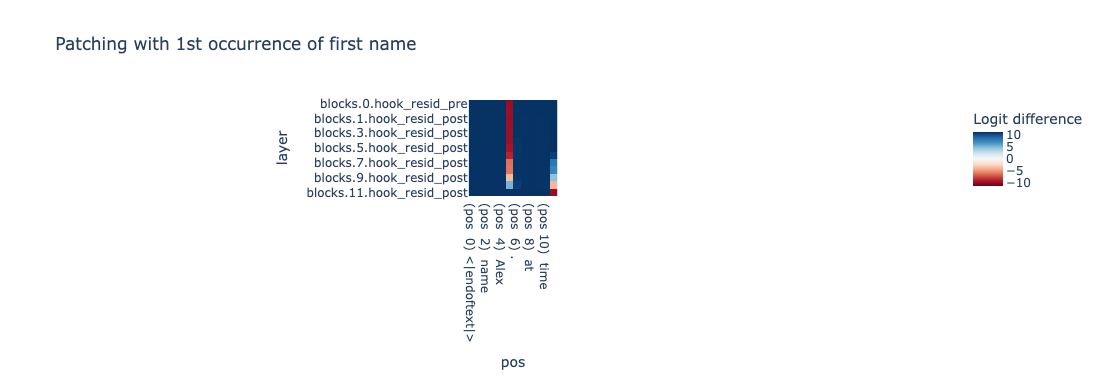

In [38]:
# Plot
token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]
imshow(patching_effect, xticks=token_labels, yticks=layers, xlabel="pos", ylabel="layer",
       zlabel="Logit difference", title="Patching with 1st occurrence of first name", width=800, height=380)